In [1]:
# === Colab 先頭セル：認証→(必要なら)DL→PKL自動検出→DATA_PATH/SUBJECT_ID設定→data読込 ===
!pip -q install kaggle

from pathlib import Path
import sys, os, io, zipfile, glob, subprocess
import pickle
import pandas as pd  # Colab標準で入ってます

# ===== 設定 =====
DATA_ROOT = Path("/content/data")              # 展開先
DATA_ROOT.mkdir(parents=True, exist_ok=True)
PREFERRED_DATASET = None                       # 例: "owner/wesad-mirror-slug"（あれば優先）
PREFERRED_SUBJECT = "S2"                       # 既定で S2 を優先

# ===== Kaggle 認証（既に設定済みならスキップ）=====
KAGGLE_JSON = Path("/root/.kaggle/kaggle.json")
if not KAGGLE_JSON.exists():
    try:
        from google.colab import files
        print("▶ kaggle.json をアップロードしてください（Kaggle: Account → Create New API Token）")
        uploaded = files.upload()
        assert "kaggle.json" in uploaded, "kaggle.json を選択してください"
        os.makedirs("/root/.kaggle", exist_ok=True)
        os.replace("kaggle.json", str(KAGGLE_JSON))
        os.chmod(KAGGLE_JSON, 0o600)
        print("✅ kaggle.json 設定完了")
    except Exception as e:
        print("❌ Kaggle認証が未設定です。環境変数方式を使う場合は以下を有効化してください：")
        print("# os.environ['KAGGLE_USERNAME'] = 'your_username'")
        print("# os.environ['KAGGLE_KEY'] = 'your_api_key'")
        raise

# ===== slug 決定 =====
def pick_slug(preferred: str | None) -> str:
    if preferred:
        return preferred
    # "wesad" を検索してスコア順に並べ、最有力を選ぶ
    res = subprocess.run(["kaggle","datasets","list","-s","wesad","--csv"],
                         capture_output=True, text=True)
    if res.returncode != 0:
        raise RuntimeError("kaggle search failed:\n" + res.stderr)
    df = pd.read_csv(io.StringIO(res.stdout))
    if df.empty:
        raise SystemExit("Kaggle上で 'wesad' が見つかりませんでした。")
    df["score"] = 0
    title = df["title"].fillna("").str.lower()
    df.loc[title.str.contains("wesad"), "score"] += 5
    df.loc[title.str.contains("wearable"), "score"] += 2
    df.loc[title.str.contains("stress"), "score"] += 1
    df = df.sort_values(["score","downloadCount"], ascending=[False, False])
    return df["ref"].iloc[0]

slug = pick_slug(PREFERRED_DATASET)
print("Chosen slug:", slug)

# 規約未同意だと 403 になる → URL を開いて同意してから再実行
chk = subprocess.run(["kaggle","datasets","files","-d", slug], capture_output=True, text=True)
if "403" in chk.stderr or "Forbidden" in chk.stderr:
    print("❗403 Forbidden: 規約同意が必要です。以下を開いて同意後、セルを再実行してください：")
    print("   https://www.kaggle.com/datasets/" + slug)
    raise SystemExit

# ===== ダウンロード＆解凍（既にPKLがあればスキップ）=====
def ensure_download(slug: str):
    if any(DATA_ROOT.rglob("*.pkl")):
        print("⏭️ 既にPKLが見つかりました。ダウンロードをスキップします。")
        return
    print("▶ ダウンロード中:", slug)
    subprocess.run(["kaggle","datasets","download","-d", slug, "-p", str(DATA_ROOT)], check=True)
    zips = list(DATA_ROOT.glob("*.zip"))
    if not zips:
        print("⚠️ ZIPが見つかりません。データ構成により直下ZIPでない可能性があります。")
    for z in zips:
        print("  解凍:", z.name)
        with zipfile.ZipFile(z) as f:
            f.extractall(DATA_ROOT)
        z.unlink()

ensure_download(slug)

# ===== PKL 検出 → DATA_PATH / SUBJECT_ID 設定 =====
pkls = sorted(DATA_ROOT.rglob("S*.pkl"))
if not pkls:
    print("⚠️ PKLが見つかりません。展開内容を確認します：")
    os.system(f"ls -R {DATA_ROOT} | sed -n '1,200p'")
    raise SystemExit("このミラーは PKL ではなく CSV などの可能性があります。別の slug を指定するか、Drive上のWESADを使ってください。")

# PREFERRED_SUBJECT を優先。なければ先頭を使う
pkl_path = next((p for p in pkls if p.name == f"{PREFERRED_SUBJECT}.pkl"), pkls[0])
SUBJECT_ID = pkl_path.stem

# 元ノートは f\"{DATA_PATH}{SUBJECT_ID}/{SUBJECT_ID}.pkl\" 形式 → S2ディレクトリの一つ上を DATA_PATH に設定し、末尾に '/'
DATA_PATH = str(pkl_path.parent.parent) + "/"

print("DATA_PATH =", DATA_PATH)
print("SUBJECT_ID =", SUBJECT_ID)
print("PKL path  =", pkl_path)

# ===== 読み込み（'data' を確実に定義）=====
with open(pkl_path, "rb") as f:
    data = pickle.load(f, encoding="latin1")

print("Loaded OK. type(data) =", type(data))
if isinstance(data, dict):
    print("Top-level keys:", list(data.keys())[:10])


Chosen slug: orvile/wesad-wearable-stress-affect-detection-dataset
⏭️ 既にPKLが見つかりました。ダウンロードをスキップします。
DATA_PATH = /content/data/WESAD/
SUBJECT_ID = S2
PKL path  = /content/data/WESAD/S2/S2.pkl
Loaded OK. type(data) = <class 'dict'>
Top-level keys: ['signal', 'label', 'subject']


# このノートブックは Kaggle 上の公開ノートブックを参考にしています。  
# WESAD データセット (Schmidt et al., 2018) を用いた HRV ベースのストレス分類のベースライン実装です。


In [5]:
# 依存の導入
!pip -q install neurokit2 pywavelets seaborn

# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import pywt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')

# Colabでは /kaggle/input を歩く必要はありません（Kaggle環境ではないため）
# ↓ このループは削除してOK
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     ...


In [3]:
pip install neurokit2

In [6]:
# --- Ensure data exists (guard) ---
from pathlib import Path
import pickle
if 'data' not in globals():
    assert 'pkl_path' in globals(), "pkl_path が未定義です。先頭セルを実行してください。"
    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

# SUBJECT_ID は先頭セルのものを使う（上書きしない）
print(f"Using DATA_PATH={DATA_PATH}  SUBJECT_ID={SUBJECT_ID}")
print(f"PKL path={pkl_path}")

# --- Data Structure Overview ---
from collections.abc import Mapping
print("\n--- Data Structure Overview ---")
if isinstance(data, Mapping):
    print("Top-level keys:", list(data.keys())[:20])

    # WESADでよくある3パターンを吸収
    signal_data = None
    if 'signal' in data:
        signal_data = data['signal']
    elif 'signals' in data:
        signal_data = data['signals']
    elif any(k in data for k in ('chest', 'wrist')):
        signal_data = {'chest': data.get('chest'), 'wrist': data.get('wrist')}

    if isinstance(signal_data, Mapping):
        print("Keys in signal data:", list(signal_data.keys())[:20])
    else:
        print("signal_data structure not dict-like:", type(signal_data))
else:
    print("data is not a dict:", type(data))


Using DATA_PATH=/content/data/WESAD/  SUBJECT_ID=S2
PKL path=/content/data/WESAD/S2/S2.pkl

--- Data Structure Overview ---
Top-level keys: ['signal', 'label', 'subject']
Keys in signal data: ['chest', 'wrist']


ここのセルは必要ないかも

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk # Excellent for biosignal processing
import pywt # For wavelet transforms
import seaborn as sns

# --- Configuration ---
# IMPORTANT: Adjust this path to where your WESAD dataset is located on Kaggle
#DATA_PATH = '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/'
SUBJECT_ID = 'S2' # Example subject ID to process
ECG_SAMPLING_RATE_RESP = 700 # Hz (from WESAD documentation for RespiBAN ECG)
LABEL_SAMPLING_RATE = 700 # Hz (from WESAD documentation for labels)
HRV_INTERPOLATION_RATE = 4 # Hz (Common for HRV spectral analysis, as per RHRV example in the wavelet paper)
WINDOW_SIZE_SEC = 300 # 5 minutes for rolling feature aggregation
WINDOW_OVERLAP_SEC = 60 # 1 minute overlap for smooth features

# Set a style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')

print(f"--- Preprocessing for Subject: {SUBJECT_ID} ---")

# 1. Load Data
print(f"Loading data for {SUBJECT_ID} from {DATA_PATH}{SUBJECT_ID}/{SUBJECT_ID}.pkl...")
try:
    with open(f"{DATA_PATH}{SUBJECT_ID}/{SUBJECT_ID}.pkl", 'rb') as f:
        data = pickle.load(f, encoding='latin1') # Use latin1 for Python 3 compatibility with older pickle files
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: {DATA_PATH}{SUBJECT_ID}/{SUBJECT_ID}.pkl not found. Please check DATA_PATH.")
    exit()

--- Preprocessing for Subject: S2 ---
Loading data for S2 from /content/data/WESAD/S2/S2.pkl...
Data loaded successfully.


In [7]:
print("\n--- Data Structure Overview ---")
print(f"Keys in loaded data: {data.keys()}")

signal_data = data['signal']
print(f"Keys in signal data: {signal_data.keys()}")

chest_data = signal_data['chest']
print(f"Keys in chest data: {chest_data.keys()}")

# Extract ECG and labels
ecg_signal = chest_data['ECG']
labels = data['label']

print(f"ECG signal shape: {ecg_signal.shape}")
print(f"Labels shape: {labels.shape}")


--- Data Structure Overview ---
Keys in loaded data: dict_keys(['signal', 'label', 'subject'])
Keys in signal data: dict_keys(['chest', 'wrist'])
Keys in chest data: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
ECG signal shape: (4255300, 1)
Labels shape: (4255300,)


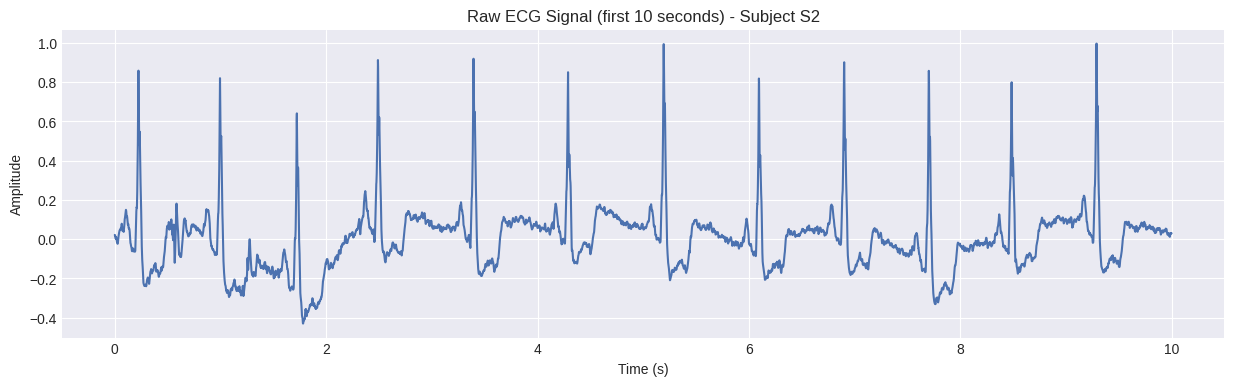

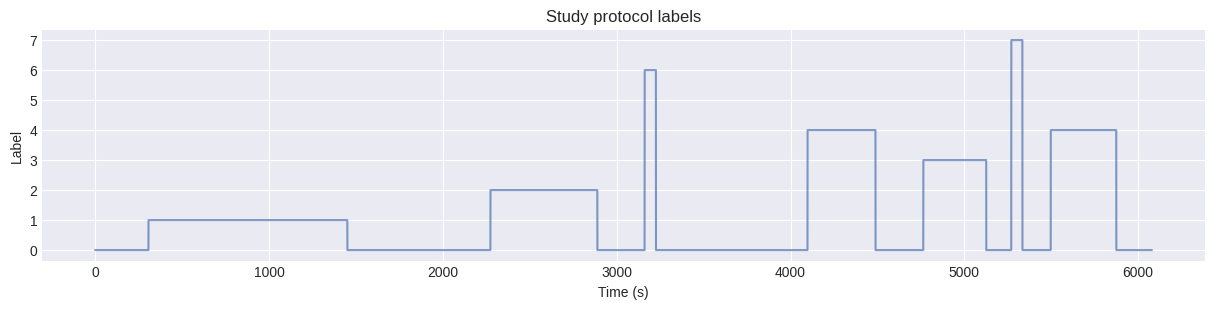

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(len(ecg_signal[:ECG_SAMPLING_RATE_RESP*10])) / ECG_SAMPLING_RATE_RESP,
         ecg_signal[:ECG_SAMPLING_RATE_RESP*10])
plt.title(f'Raw ECG Signal (first 10 seconds) - Subject {SUBJECT_ID}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(np.arange(len(labels)) / LABEL_SAMPLING_RATE, labels, alpha=0.7)
plt.title('Study protocol labels')
plt.xlabel('Time (s)')
plt.ylabel('Label')
plt.show()


In [9]:
print("\n--- II. RR Interval Extraction from ECG ---")

print(f"Processing ECG signal of length {len(ecg_signal)} samples at {ECG_SAMPLING_RATE_RESP} Hz...")

# Initialize variables to safe defaults
rr_df = pd.DataFrame()
rpeaks_indices = np.array([])

try:
    # Clean ECG signal
    print("Cleaning ECG signal...")
    cleaned_ecg = nk.ecg_clean(ecg_signal, sampling_rate=ECG_SAMPLING_RATE_RESP)

    # Detect R-peaks
    print("Detecting R-peaks...")
    _, rpeaks = nk.ecg_peaks(cleaned_ecg, sampling_rate=ECG_SAMPLING_RATE_RESP)

    # Extract R-peak indices
    rpeaks_indices = rpeaks['ECG_R_Peaks']

    print(f"Detected {len(rpeaks_indices)} R-peaks.")

    if len(rpeaks_indices) > 1:
        # Compute RR intervals in ms
        rr_intervals_ms = np.diff(rpeaks_indices) / ECG_SAMPLING_RATE_RESP * 1000
        rr_times_sec = rpeaks_indices[1:] / ECG_SAMPLING_RATE_RESP

        rr_df = pd.DataFrame({'Time_sec': rr_times_sec, 'RR_ms': rr_intervals_ms})

        print(f"Calculated {len(rr_intervals_ms)} RR intervals.")
        print(f"First 5 RR intervals:\n{rr_df.head()}")
    else:
        print("Too few R-peaks to compute RR intervals.")

except Exception as e:
    print(f"An error occurred: {e}")



--- II. RR Interval Extraction from ECG ---
Processing ECG signal of length 4255300 samples at 700 Hz...
Cleaning ECG signal...
Detecting R-peaks...
Detected 7250 R-peaks.
Calculated 7249 RR intervals.
First 5 RR intervals:
   Time_sec       RR_ms
0  1.725714  727.142857
1  2.492857  767.142857
2  3.397143  904.285714
3  4.288571  891.428571
4  5.195714  907.142857


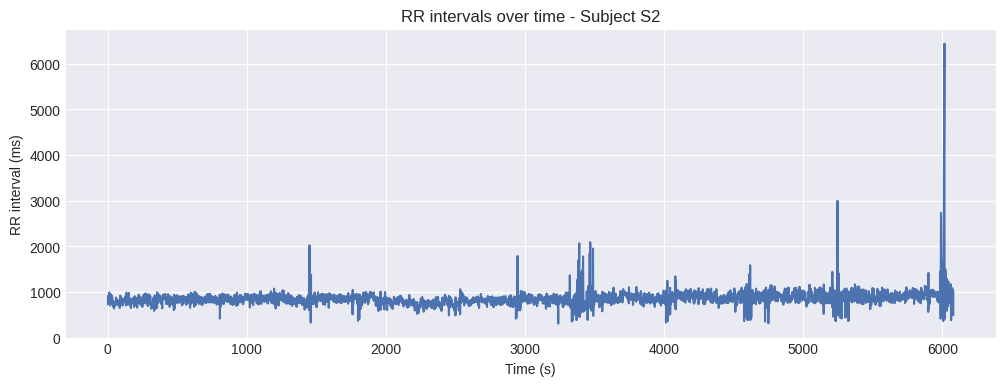

In [10]:
plt.figure(figsize=(12,4))
plt.plot(rr_df['Time_sec'], rr_df['RR_ms'])
plt.title(f'RR intervals over time - Subject {SUBJECT_ID}')
plt.xlabel('Time (s)')
plt.ylabel('RR interval (ms)')
plt.show()

In [11]:
print("\n--- Sliding window HRV feature extraction ---")

WINDOW_SIZE_SEC = 120  # try 2 minutes
WINDOW_STEP_SEC = 60   # 1-minute overlap
window_size_samples = WINDOW_SIZE_SEC * ECG_SAMPLING_RATE_RESP
step_size_samples = WINDOW_STEP_SEC * ECG_SAMPLING_RATE_RESP

print(f"Window size: {window_size_samples} samples")
print(f"Step size: {step_size_samples} samples")

hrv_features_list = []

for start in range(0, len(ecg_signal) - window_size_samples, step_size_samples):
    end = start + window_size_samples
    window_center_sec = (start + end) / 2 / ECG_SAMPLING_RATE_RESP

    # Find R-peaks in this window
    peaks_in_window = rpeaks_indices[(rpeaks_indices >= start) & (rpeaks_indices < end)] - start

    print(f"Window starting at {start}: {len(peaks_in_window)} peaks")

    if len(peaks_in_window) > 2:
        # Build peaks DataFrame expected by nk.hrv
        peaks_df = pd.DataFrame({"ECG_R_Peaks": np.zeros(window_size_samples, dtype=bool)})
        peaks_df.loc[peaks_in_window, "ECG_R_Peaks"] = True

        try:
            hrv = nk.hrv(peaks_df, sampling_rate=ECG_SAMPLING_RATE_RESP, show=False)
            hrv_row = hrv.iloc[0].to_dict()

            # Add time and label
            window_labels = labels[start:end]
            most_common_label = np.bincount(window_labels).argmax()
            hrv_row["Time"] = window_center_sec
            hrv_row["Label"] = most_common_label

            hrv_features_list.append(hrv_row)

        except Exception as e:
            print(f"Error computing HRV in window starting at {start}: {e}")
    else:
        print(f"Too few peaks in window starting at {start}, skipping.")

# Convert to DataFrame
df_features = pd.DataFrame(hrv_features_list)
print("\n--- HRV Feature Table ---")
print("Shape:", df_features.shape)
print("Columns:", df_features.columns)
if not df_features.empty:
    print("Unique labels:", df_features["Label"].unique())
    print(df_features.head())
else:
    print("No HRV features extracted.")



--- Sliding window HRV feature extraction ---
Window size: 84000 samples
Step size: 42000 samples
Window starting at 0: 151 peaks
Window starting at 42000: 151 peaks
Window starting at 84000: 150 peaks
Window starting at 126000: 147 peaks
Window starting at 168000: 152 peaks
Window starting at 210000: 151 peaks
Window starting at 252000: 145 peaks
Window starting at 294000: 147 peaks
Window starting at 336000: 146 peaks
Window starting at 378000: 144 peaks
Window starting at 420000: 143 peaks
Window starting at 462000: 143 peaks
Window starting at 504000: 145 peaks
Window starting at 546000: 146 peaks
Window starting at 588000: 144 peaks
Window starting at 630000: 142 peaks
Window starting at 672000: 141 peaks
Window starting at 714000: 141 peaks
Window starting at 756000: 139 peaks
Window starting at 798000: 140 peaks
Window starting at 840000: 143 peaks
Window starting at 882000: 147 peaks
Window starting at 924000: 153 peaks
Window starting at 966000: 151 peaks
Window starting at 1

/usr/local/lib/python3.11/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Window starting at 4074000: 129 peaks


/usr/local/lib/python3.11/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Window starting at 4116000: 128 peaks


/usr/local/lib/python3.11/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Window starting at 4158000: 123 peaks

--- HRV Feature Table ---
Shape: (100, 93)
Columns: Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF',
       'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2',
       'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP',
       'HRV_IALS', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI',
       'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d',
       'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd',
       'HRV_SDNNa', 'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width',
       'HRV_MFDFA_alpha1_Pea

/usr/local/lib/python3.11/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


In [12]:
print("\n--- HRV Feature Table ---")
print("Shape:", df_features.shape)
print("Columns:", df_features.columns)
print("Unique labels:", df_features["Label"].unique())
print(df_features.head())


--- HRV Feature Table ---
Shape: (100, 93)
Columns: Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF',
       'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2',
       'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP',
       'HRV_IALS', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI',
       'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d',
       'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd',
       'HRV_SDNNa', 'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width',
       'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Mean',
       'H

In [13]:
print(f"Window starting at {start}: {len(peaks_in_window)} peaks")

Window starting at 4158000: 123 peaks


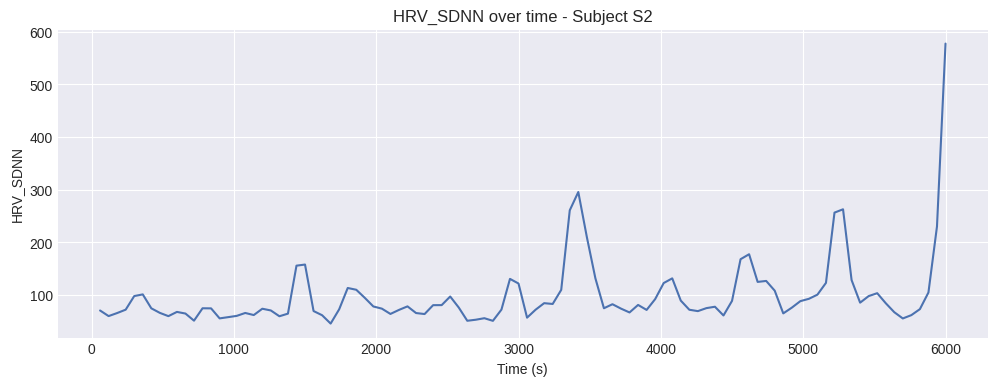

In [14]:
plt.figure(figsize=(12,4))
plt.plot(df_features['Time'], df_features['HRV_SDNN'])
plt.title(f'HRV_SDNN over time - Subject {SUBJECT_ID}')
plt.xlabel('Time (s)')
plt.ylabel('HRV_SDNN')
plt.show()

In [15]:

df_features["Label"] = df_features["Label"].map(lambda x: x if x in [0,1,2,3] else 0)

In [16]:
df_features = df_features[df_features["Label"].isin([0,1,2,3])]

In [17]:
print(df_features["Label"].value_counts())

Label
0    64
1    19
2    11
3     6
Name: count, dtype: int64


In [18]:
df_features = df_features.fillna(df_features.median())

In [19]:
nan_counts = df_features.isna().sum()
df_features = df_features.drop(columns=nan_counts[nan_counts > (0.2*len(df_features))].index)

In [20]:
X = df_features.drop(columns=["Time", "Label"])
y = df_features["Label"]

In [21]:
print("Final X shape:", X.shape)
print("Final y distribution:\n", y.value_counts())

Final X shape: (100, 83)
Final y distribution:
 Label
0    64
1    19
2    11
3     6
Name: count, dtype: int64


In [22]:
print("Number of columns dropped due to >20% NaN:", len(nan_counts[nan_counts > (0.2*len(df_features))]))
print("Remaining feature columns:", X.shape[1])

Number of columns dropped due to >20% NaN: 8
Remaining feature columns: 83


In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.67      0.50      0.57         4
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         1

    accuracy                           0.80        20
   macro avg       0.62      0.61      0.61        20
weighted avg       0.75      0.80      0.77        20

[[12  1  0  0]
 [ 2  2  0  0]
 [ 0  0  2  0]
 [ 1  0  0  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


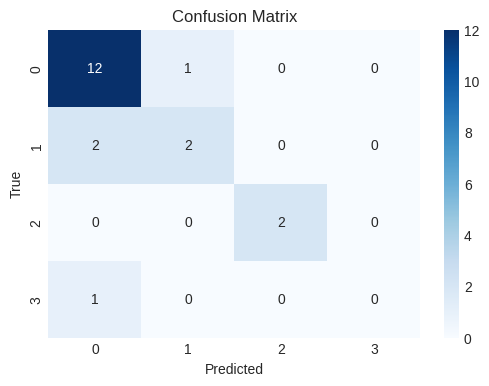

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
print("Test accuracy:", clf.score(X_test, y_test))

Test accuracy: 0.8


In [28]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_scaled, y, cv=5)
print("Cross-validation accuracy: %.2f ± %.2f" % (scores.mean(), scores.std()))

Cross-validation accuracy: 0.73 ± 0.07


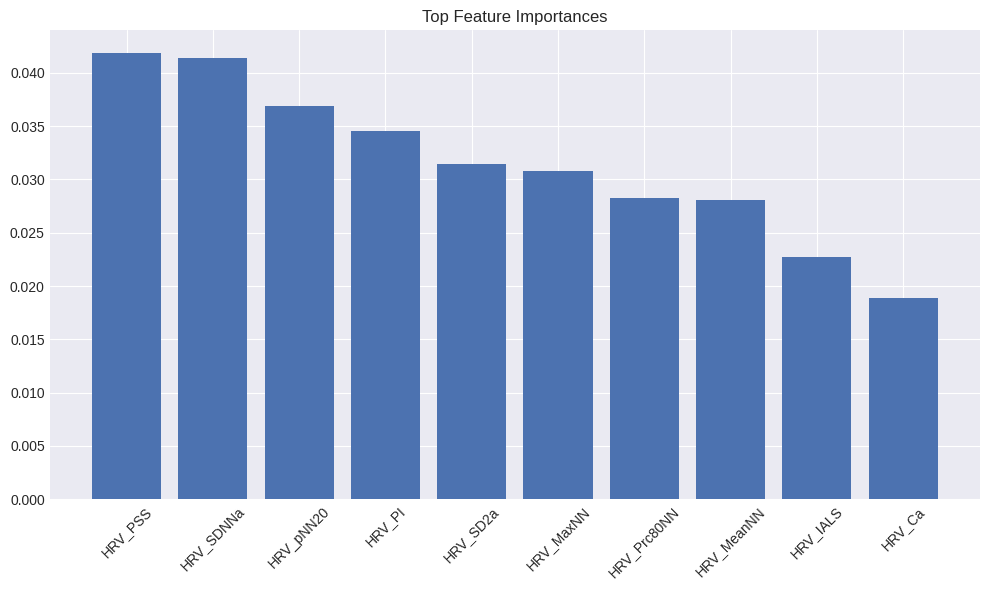

In [29]:
import matplotlib.pyplot as plt
import numpy as np

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10

plt.figure(figsize=(10,6))
plt.title("Top Feature Importances")
plt.bar(range(top_n), importances[indices[:top_n]], align='center')
plt.xticks(range(top_n), np.array(X.columns)[indices[:top_n]], rotation=45)
plt.tight_layout()
plt.show()

In [30]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk

# Config
DATA_PATH = '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/'
subject_ids = ['S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S13','S14','S15','S16','S17']
ECG_SAMPLING_RATE_RESP = 700
WINDOW_SIZE_SEC = 120
WINDOW_STEP_SEC = 60
window_size_samples = WINDOW_SIZE_SEC * ECG_SAMPLING_RATE_RESP
step_size_samples = WINDOW_STEP_SEC * ECG_SAMPLING_RATE_RESP

# Store all detailed results
all_results = []

def process_subject(subject_id):
    print(f"\n=== Processing {subject_id} ===")
    try:
        with open(f"{DATA_PATH}{subject_id}/{subject_id}.pkl", 'rb') as f:
            data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print(f"Could not load data for {subject_id}: {e}")
        return None

    # Extract ECG and labels
    ecg_signal = data['signal']['chest']['ECG']
    labels = data['label']

    # Clean ECG & find R-peaks
    cleaned_ecg = nk.ecg_clean(ecg_signal, sampling_rate=ECG_SAMPLING_RATE_RESP)
    _, rpeaks = nk.ecg_peaks(cleaned_ecg, sampling_rate=ECG_SAMPLING_RATE_RESP)
    rpeaks_indices = rpeaks['ECG_R_Peaks']

    # Sliding window HRV features
    hrv_features_list = []
    for start in range(0, len(ecg_signal) - window_size_samples, step_size_samples):
        end = start + window_size_samples
        window_center_sec = (start + end) / 2 / ECG_SAMPLING_RATE_RESP

        peaks_in_window = rpeaks_indices[(rpeaks_indices >= start) & (rpeaks_indices < end)] - start

        if len(peaks_in_window) > 2:
            peaks_df = pd.DataFrame({"ECG_R_Peaks": np.zeros(window_size_samples, dtype=bool)})
            peaks_df.loc[peaks_in_window, "ECG_R_Peaks"] = True
            try:
                hrv = nk.hrv(peaks_df, sampling_rate=ECG_SAMPLING_RATE_RESP, show=False)
                hrv_row = hrv.iloc[0].to_dict()
                window_labels = labels[start:end]
                most_common_label = np.bincount(window_labels).argmax()
                hrv_row["Time"] = window_center_sec
                hrv_row["Label"] = most_common_label
                hrv_features_list.append(hrv_row)
            except Exception as e:
                continue

    if not hrv_features_list:
        print(f"No HRV features extracted for {subject_id}")
        return None

    df_features = pd.DataFrame(hrv_features_list)
    df_features["Label"] = df_features["Label"].map(lambda x: x if x in [0,1,2,3] else 0)
    df_features = df_features[df_features["Label"].isin([0,1,2,3])]
    df_features = df_features.fillna(df_features.median())
    nan_counts = df_features.isna().sum()
    df_features = df_features.drop(columns=nan_counts[nan_counts > (0.2*len(df_features))].index)

    X = df_features.drop(columns=["Time", "Label"])
    y = df_features["Label"]

    if len(y.unique()) < 2 or len(y) < 10:
        print(f"Not enough data to train for {subject_id}")
        return None

    X_scaled = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])

    return {
        'subject': subject_id,
        'accuracy': acc,
        'macro_f1': macro_f1,
        'n_samples': len(y),
        'confusion_matrix': cm
    }

# Process all subjects
for subject_id in subject_ids:
    res = process_subject(subject_id)
    if res:
        all_results.append(res)

# Build summary DataFrame
df_results = pd.DataFrame([{
    'subject': r['subject'],
    'accuracy': r['accuracy'],
    'macro_f1': r['macro_f1'],
    'n_samples': r['n_samples']
} for r in all_results]).sort_values(by='accuracy', ascending=False)

print("\n=== Summary Table (sorted by accuracy) ===")
print(df_results)

# Plot: per-subject confusion matrices
for r in all_results:
    plt.figure(figsize=(4,4))
    sns.heatmap(r['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
    plt.title(f"Confusion matrix: {r['subject']}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot: average normalized confusion matrix
cms = [r['confusion_matrix'] for r in all_results]
sum_cm = np.sum(cms, axis=0)
norm_cm = sum_cm / sum_cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(norm_cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title('Average normalized confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot: barplots of accuracy and macro F1
plt.figure(figsize=(10,5))
sns.barplot(x='subject', y='accuracy', data=df_results, order=df_results['subject'])
plt.ylim(0,1)
plt.title('Accuracy per subject')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='subject', y='macro_f1', data=df_results, order=df_results['subject'])
plt.ylim(0,1)
plt.title('Macro F1 per subject')
plt.ylabel('Macro F1')
plt.show()

# Print mean ± std
mean_acc = df_results['accuracy'].mean()
std_acc = df_results['accuracy'].std()
mean_f1 = df_results['macro_f1'].mean()
std_f1 = df_results['macro_f1'].std()

print(f"\nMean accuracy: {mean_acc:.2f} ± {std_acc:.2f}")
print(f"Mean macro F1: {mean_f1:.2f} ± {std_f1:.2f}")



=== Processing S2 ===
Could not load data for S2: [Errno 2] No such file or directory: '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S2/S2.pkl'

=== Processing S3 ===
Could not load data for S3: [Errno 2] No such file or directory: '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S3/S3.pkl'

=== Processing S4 ===
Could not load data for S4: [Errno 2] No such file or directory: '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S4/S4.pkl'

=== Processing S5 ===
Could not load data for S5: [Errno 2] No such file or directory: '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S5/S5.pkl'

=== Processing S6 ===
Could not load data for S6: [Errno 2] No such file or directory: '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S6/S6.pkl'

=== Processing S7 ===
Could not load data for S7: [Errno 2] No such file or directory: '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S7/S7.pkl

KeyError: 'accuracy'

In [32]:


# 先頭セルで定義済みの DATA_PATH があれば優先し、なければ /content/data を起点に探索
ROOTS = []
if 'DATA_PATH' in globals():
    ROOTS.append(Path(DATA_PATH))
ROOTS += [Path("/content/data"), Path("/kaggle/input")]  # 存在するディレクトリだけ使われます

PKL_INDEX = {}
for root in ROOTS:
    if root.exists():
        for p in root.rglob("S*/S*.pkl"):  # 例: .../WESAD/S2/S2.pkl
            PKL_INDEX[p.stem] = p  # {'S2': PosixPath(.../S2.pkl), ...}

if not PKL_INDEX:
    raise RuntimeError("S*.pkl が見つかりません。KaggleミラーがCSVのみの可能性があります。"
                       "データ配置を確認してください。（/content/data 以下に WESAD/S*/S*.pkl があるか）")

print(f"Found {len(PKL_INDEX)} subjects:", sorted(PKL_INDEX)[:10], "...")

rows = []
def process_subject_from_pkl(pkl_path):
    """
    1) S*/S*.pkl を読み込み
    2) ECG を抽出して R-peak 検出（neurokit2）
    3) 窓ごと（WINDOW_SIZE_SEC / WINDOW_OVERLAP_SEC）に特徴量生成
       - HR の平均/分散
       - RR間隔から SDNN / RMSSD
    4) ラベル配列を多数決で窓ラベルにマッピング（stress=2 を優先、無ければ最大値をstress扱い）
    5) 単純なロジスティック回帰で学習→accuracy, macro_f1 を返す
    """
    import numpy as np
    import pandas as pd
    import pickle
    from pathlib import Path
    import neurokit2 as nk
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score

    # ---- 0) 読み込み ----
    with open(pkl_path, "rb") as f:
        d = pickle.load(f, encoding="latin1")

    # ---- 1) ECG 抽出（大小文字や階層の違いにロバスト）----
    def find_array_by_key(obj, substr):
        """辞書/リストを再帰探索して key に substr を含む np.ndarray を返す"""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(k, str) and substr in k.lower() and isinstance(v, np.ndarray):
                    return v
            for v in obj.values():
                out = find_array_by_key(v, substr)
                if out is not None:
                    return out
        elif isinstance(obj, (list, tuple)):
            for v in obj:
                out = find_array_by_key(v, substr)
                if out is not None:
                    return out
        return None

    # よくある構造: d['signal']['chest']['ECG']
    ecg = None
    try:
        ecg = d['signal']['chest']['ECG']
    except Exception:
        pass
    if ecg is None:
        ecg = find_array_by_key(d, 'ecg')
    if ecg is None:
        raise ValueError("ECG 配列が見つかりませんでした。")

    ecg = np.asarray(ecg).astype(float).flatten()
    fs = int(globals().get("ECG_SAMPLING_RATE_RESP", 700))

    # ---- 2) ラベル取得（長さがECGと同じ配列を優先）----
    label = None
    # よくある: d['label']
    if isinstance(d, dict) and 'label' in d and isinstance(d['label'], np.ndarray):
        label = d['label'].astype(int).flatten()
    if label is None or label.shape[0] != ecg.shape[0]:
        # 他の場所にある可能性
        cand = find_array_by_key(d, 'label')
        if isinstance(cand, np.ndarray):
            label = cand.astype(int).flatten()
    # 長さが合わないなら窓ラベリングできないのでスキップ
    if label is None or label.shape[0] != ecg.shape[0]:
        raise ValueError("ラベル配列が見つからないか、ECGと長さが一致しません。")

    # ---- 3) ECG 処理（neurokit2）----
    # 全体に対して一発で処理（高速・安定）
    signals, info = nk.ecg_process(ecg, sampling_rate=fs)
    peaks_idx = np.where(signals["ECG_R_Peaks"].values == 1)[0]

    # ---- 4) 窓定義 ----
    win = int(globals().get("WINDOW_SIZE_SEC", 300) * fs)
    step = int((globals().get("WINDOW_SIZE_SEC", 300) - globals().get("WINDOW_OVERLAP_SEC", 60)) * fs)
    step = max(step, 1)

    X_rows, y_rows = [], []
    n = ecg.shape[0]
    lab_unique = np.unique(label)
    # stress ラベルの推定（WESAD慣例: 2=stress が多い）
    stress_code = 2 if 2 in lab_unique else int(lab_unique.max())

    for start in range(0, max(0, n - win + 1), step):
        end = start + win
        # R-peak を窓内に切り出し
        w_peaks = peaks_idx[(peaks_idx >= start) & (peaks_idx < end)]
        if w_peaks.size < 3:
            continue
        # RR(ms)
        rr_ms = np.diff(w_peaks) / fs * 1000.0
        if rr_ms.size < 2:
            continue

        # HR系列（neurokit2 の ECG_Rate）はサンプルごと、窓内統計を使う
        hr_seg = signals["ECG_Rate"].iloc[start:end].values
        if hr_seg.size == 0:
            continue

        # 特徴量
        hr_mean = float(np.nanmean(hr_seg))
        hr_std = float(np.nanstd(hr_seg))
        sdnn = float(np.nanstd(rr_ms))
        rmssd = float(np.sqrt(np.nanmean(np.diff(rr_ms)**2)))

        X_rows.append([hr_mean, hr_std, sdnn, rmssd])

        # ラベル多数決
        lab_win = label[start:end]
        # 0/NaN が混ざる可能性を考慮しつつ多数決
        vals, counts = np.unique(lab_win[~np.isnan(lab_win)], return_counts=True)
        if vals.size == 0:
            continue
        maj = int(vals[np.argmax(counts)])
        y_rows.append(1 if maj == stress_code else 0)

    if len(X_rows) < 10 or len(set(y_rows)) < 2:
        raise ValueError("有効な窓が十分でないか、単一クラスしかありません。")

    X = pd.DataFrame(X_rows, columns=["hr_mean","hr_std","sdnn","rmssd"])
    y = np.array(y_rows, dtype=int)

    # ---- 5) 学習・評価 ----
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000))
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = float(accuracy_score(y_test, y_pred))
    mf1 = float(f1_score(y_test, y_pred, average="macro"))

    return {"accuracy": acc, "macro_f1": mf1, "n_samples": int(len(y))}


for sid in sorted(PKL_INDEX.keys(), key=lambda s: int(s[1:])):  # S2→2 でソート
    pkl_path = PKL_INDEX[sid]
    print(f"=== Processing {sid} ===")
    try:
        metrics = process_subject_from_pkl(pkl_path)
        rows.append({"subject": sid, **metrics})
    except NotImplementedError as e:
        # まずはここにあなたの処理を実装してから実行してください
        raise
    except Exception as e:
        print(f"Skip {sid}: {e}")

# 失敗対策：空やキー不足なら安全に抜ける
if not rows:
    raise RuntimeError("どの被験者も処理できませんでした。上のログの FileNotFound/その他エラーを解消してください。")

df = pd.DataFrame(rows)
missing = [k for k in ["accuracy","macro_f1","n_samples"] if k not in df.columns]
if missing:
    raise KeyError(f"結果DataFrameに必要な列がありません: {missing}  "
                   f"→ process_subject_from_pkl の戻り値を {{'accuracy','macro_f1','n_samples'}} を含む辞書にしてください。")

df = df.sort_values("accuracy", ascending=False).reset_index(drop=True)
display(df.head())


Found 15 subjects: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4'] ...
=== Processing S2 ===
=== Processing S3 ===
=== Processing S4 ===
=== Processing S5 ===
=== Processing S6 ===
=== Processing S7 ===
=== Processing S8 ===
=== Processing S9 ===
=== Processing S10 ===
=== Processing S11 ===
=== Processing S13 ===
=== Processing S14 ===
=== Processing S15 ===
=== Processing S16 ===
=== Processing S17 ===


,subject,accuracy,macro_f1,n_samples
0,S3,1.000000,1.000000,107
1,S8,1.000000,1.000000,90
2,S6,0.965517,0.918768,116
3,S5,0.961538,0.917460,103
4,S17,0.960000,0.916944,97
